In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import datetime
sns.set()

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data_utils

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier

# Data Preprocessing

## Import Sentiment and Price Data for Bitcoin

In [2]:
#load dataset
df = pd.read_csv("cryptodata/btc_reddit.csv")
#Drop irrelevant columns
df = df.drop(['cryptoId','start','count','duration','open', 'high', 'low', 'source', 'average', 'std','negative','positive'], axis=1)

## Label the data according to their future 10 day price change

In [3]:
#labeling function: 1=BUY, 0=HOLD, -1=SELL
def label(x):
    if x > 0.03: 
        return 2 #BUY
    elif x < -0.03: 
        return 0 #SELL`
    else:
        return 1 #HOLD

## Add new features 

### First approach: 
#### -We have 3 main sources of historical information: Price, Volume and Sentiment score.
#### -For each one of these, we create 4 moving averages which indicate their trend respectively (for the previous  3,7,10 and 30 days).
#### -So, we have 12 features in total.

In [4]:
#Create the sentiment score moving averages (trends)
df['3_day_score_average'] = df['score'].rolling(window=3).mean()
df['7_day_score_average'] = df['score'].rolling(window=7).mean()
df['14_day_score_average'] = df['score'].rolling(window=10).mean()
df['30_day_score_average'] = df['score'].rolling(window=30).mean()

#Create the btc closing price moving averages (trends)
df['3_day_price_average'] = df['close'].rolling(window=3).mean()
df['7_day_price_average'] = df['close'].rolling(window=7).mean()
df['14_day_price_average'] = df['close'].rolling(window=10).mean()
df['30_day_price_average'] = df['close'].rolling(window=30).mean()

#Create the btc daily volume moving averages (trends)
df['3_day_volume_average'] = df['volumeUSD'].rolling(window=3).mean()
df['7_day_volume_average'] = df['volumeUSD'].rolling(window=7).mean()
df['14_day_volume_average'] = df['volumeUSD'].rolling(window=10).mean()
df['30_day_volume_average'] = df['volumeUSD'].rolling(window=30).mean()

#Apply the labels
df['10_day_future_price_change'] = df['close'].pct_change(periods=-10)*-1
df['label'] = df['10_day_future_price_change'].apply(label)

#Drop columns that won't be used as inputs
df = df.drop(['score', 'close', 'volumeUSD', '10_day_future_price_change'], axis=1)

#Drop nan values
df.dropna(inplace=True)

features = df.drop('label', axis=1)
target = df['label']

### Second Approach
#### Using PCA to extract the two most principal components from each of the three features
#### 6 features in total: trend_1, trend_2, volume_1, volume_2, score_1, score_2

In [5]:
'''
df_close = pd.DataFrame(df['close'])
df_score = pd.DataFrame(df['score'])
df_volume = pd.DataFrame(df['volumeUSD'])

for window in range(1,30):
    df_close[f'close_ma_{window}'] = df_close['close'].rolling(window=window).mean()
df_close.dropna(inplace=True)

for window in range(1,30):
    df_score[f'score_ma_{window}'] = df['score'].rolling(window=window).mean()
df_score.dropna(inplace=True)

for window in range(1,30):
    df_volume[f'volume_ma_{window}'] = df['volumeUSD'].rolling(window=window).mean()
df_volume.dropna(inplace=True)

df = df.iloc[28:]
df.reset_index(inplace=True)
df.drop(['index','score'], axis=1, inplace=True)

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents_close = pca.fit_transform(df_close)
principal_close_df = pd.DataFrame(data = principalComponents_close, columns = ['trend_1', 'trend_2'])

pca = PCA(n_components=2)
principalComponents_volume = pca.fit_transform(df_volume)
principal_volume_df = pd.DataFrame(data = principalComponents_volume, columns = ['volume_1', 'volume_2'])

pca = PCA(n_components=2)
principalComponents_score = pca.fit_transform(df_score)
principal_score_df = pd.DataFrame(data = principalComponents_score, columns = ['score_1', 'score_2'])
                                                                        

features = pd.merge(principal_close_df, principal_score_df, left_index=True, right_index=True)
features = pd.merge(features, principal_volume_df, left_index=True, right_index=True)


features = pd.merge(principal_close_df, principal_volume_df , left_index=True, right_index=True)
features = pd.merge(features, principal_score_df, left_index=True, right_index=True)
features.dropna(inplace=True)

df['10_day_future_price_change'] = df['close'].pct_change(periods=-10) *-1
target = df['10_day_future_price_change'].apply(label)
'''

"\ndf_close = pd.DataFrame(df['close'])\ndf_score = pd.DataFrame(df['score'])\ndf_volume = pd.DataFrame(df['volumeUSD'])\n\nfor window in range(1,30):\n    df_close[f'close_ma_{window}'] = df_close['close'].rolling(window=window).mean()\ndf_close.dropna(inplace=True)\n\nfor window in range(1,30):\n    df_score[f'score_ma_{window}'] = df['score'].rolling(window=window).mean()\ndf_score.dropna(inplace=True)\n\nfor window in range(1,30):\n    df_volume[f'volume_ma_{window}'] = df['volumeUSD'].rolling(window=window).mean()\ndf_volume.dropna(inplace=True)\n\ndf = df.iloc[28:]\ndf.reset_index(inplace=True)\ndf.drop(['index','score'], axis=1, inplace=True)\n\nfrom sklearn.decomposition import PCA\n\npca = PCA(n_components=2)\nprincipalComponents_close = pca.fit_transform(df_close)\nprincipal_close_df = pd.DataFrame(data = principalComponents_close, columns = ['trend_1', 'trend_2'])\n\npca = PCA(n_components=2)\nprincipalComponents_volume = pca.fit_transform(df_volume)\nprincipal_volume_df = p

## Create Train/Test split and normalize input features

In [6]:
# Split into train+val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(features, target, 
                                        test_size=0.3, shuffle=True)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, 
                                        test_size=0.3, shuffle=True)

In [7]:
#normalize X_train and X_test using StandarScaler()
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

## Visualize the class distribution in train/validation/test sets

In [8]:
def get_class_distribution(obj):
    count_dict = {
        "BUY": 0,
        "HOLD": 0,
        "SELL": 0,
    }
    
    for i in obj:
        if i == 0: 
            count_dict['SELL'] += 1
        elif i == 1: 
            count_dict['HOLD'] += 1
        elif i == 2: 
            count_dict['BUY'] += 1
            
    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

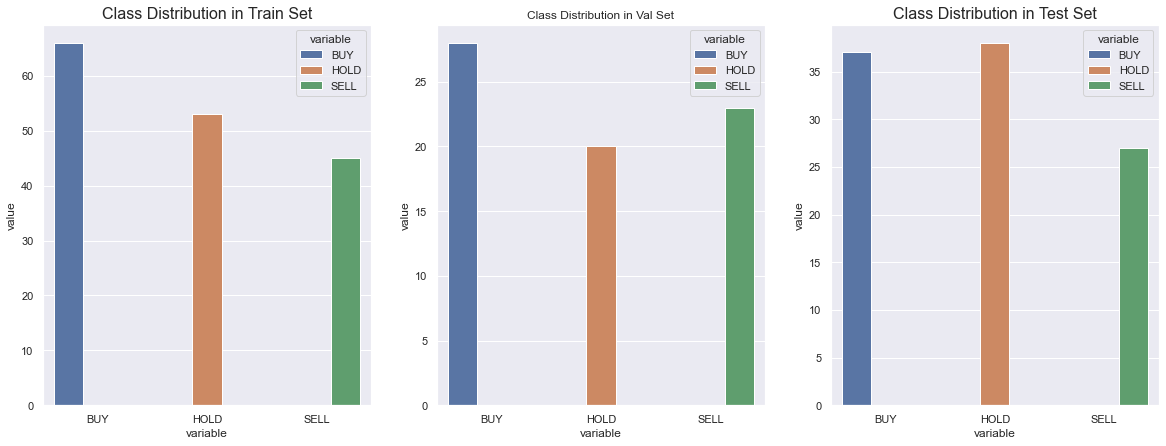

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,7))

# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), 
            x = "variable", y="value", hue="variable", ax=axes[0]).set_title('Class Distribution in Train Set', fontsize=16)

# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), 
            x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')

# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), 
            x = "variable", y="value", hue="variable", ax=axes[2]).set_title('Class Distribution in Test Set', fontsize=16)


# Neural Network

### Model Parameters

In [10]:
EPOCHS = 200
BATCH_SIZE = 64
LEARNING_RATE = 0.01
NUM_FEATURES = 12
NUM_CLASSES = 3

### Custom Dataset

In [11]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    
train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

### Dataloader

In [12]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

### Define Neural Net Architecture

In [13]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 100)
        self.layer_2 = nn.Linear(100, 100)
        self.layer_3 = nn.Linear(100, 100)
        
        self.layer_out = nn.Linear(100, num_class) 
        
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm = nn.BatchNorm1d(100)
        
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_2(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [14]:
#setting device to gpu
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device="cpu"

In [15]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

### Train our model

In [16]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [17]:
# Define dictionaries to store accuracy/epoch and loss/epoch for trainset
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [18]:
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad() 
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')



Begin training.


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.16307 | Val Loss: 1.08907 | Train Acc: 31.000| Val Acc: 38.028
Epoch 002: | Train Loss: 1.19599 | Val Loss: 1.07969 | Train Acc: 26.333| Val Acc: 33.803
Epoch 003: | Train Loss: 1.08390 | Val Loss: 1.06885 | Train Acc: 37.000| Val Acc: 36.620
Epoch 004: | Train Loss: 1.05395 | Val Loss: 1.05736 | Train Acc: 43.333| Val Acc: 36.620
Epoch 005: | Train Loss: 1.05766 | Val Loss: 1.04697 | Train Acc: 41.333| Val Acc: 35.211
Epoch 006: | Train Loss: 1.07709 | Val Loss: 1.04536 | Train Acc: 39.000| Val Acc: 36.620
Epoch 007: | Train Loss: 1.06520 | Val Loss: 1.03559 | Train Acc: 38.333| Val Acc: 35.211
Epoch 008: | Train Loss: 1.07253 | Val Loss: 1.03083 | Train Acc: 46.333| Val Acc: 35.211
Epoch 009: | Train Loss: 1.05308 | Val Loss: 1.02347 | Train Acc: 49.667| Val Acc: 36.620
Epoch 010: | Train Loss: 1.05872 | Val Loss: 1.01156 | Train Acc: 43.333| Val Acc: 39.437
Epoch 011: | Train Loss: 1.01047 | Val Loss: 1.00369 | Train Acc: 50.667| Val Acc: 42.254
Epoch 012:

Epoch 093: | Train Loss: 0.78338 | Val Loss: 0.86066 | Train Acc: 65.000| Val Acc: 54.930
Epoch 094: | Train Loss: 0.74994 | Val Loss: 0.86366 | Train Acc: 67.000| Val Acc: 56.338
Epoch 095: | Train Loss: 0.78487 | Val Loss: 0.86273 | Train Acc: 64.000| Val Acc: 56.338
Epoch 096: | Train Loss: 0.77490 | Val Loss: 0.85996 | Train Acc: 65.000| Val Acc: 56.338
Epoch 097: | Train Loss: 0.80367 | Val Loss: 0.86009 | Train Acc: 64.667| Val Acc: 56.338
Epoch 098: | Train Loss: 0.70411 | Val Loss: 0.85949 | Train Acc: 69.333| Val Acc: 56.338
Epoch 099: | Train Loss: 0.74802 | Val Loss: 0.85501 | Train Acc: 67.667| Val Acc: 56.338
Epoch 100: | Train Loss: 0.77952 | Val Loss: 0.85203 | Train Acc: 61.000| Val Acc: 56.338
Epoch 101: | Train Loss: 0.72043 | Val Loss: 0.85177 | Train Acc: 70.000| Val Acc: 56.338
Epoch 102: | Train Loss: 0.74966 | Val Loss: 0.85304 | Train Acc: 61.333| Val Acc: 56.338
Epoch 103: | Train Loss: 0.77088 | Val Loss: 0.85493 | Train Acc: 61.667| Val Acc: 56.338
Epoch 104:

Epoch 186: | Train Loss: 0.63661 | Val Loss: 0.81255 | Train Acc: 70.667| Val Acc: 60.563
Epoch 187: | Train Loss: 0.55023 | Val Loss: 0.80972 | Train Acc: 79.000| Val Acc: 60.563
Epoch 188: | Train Loss: 0.58197 | Val Loss: 0.81094 | Train Acc: 76.333| Val Acc: 60.563
Epoch 189: | Train Loss: 0.54875 | Val Loss: 0.81109 | Train Acc: 80.667| Val Acc: 60.563
Epoch 190: | Train Loss: 0.60269 | Val Loss: 0.80829 | Train Acc: 74.000| Val Acc: 61.972
Epoch 191: | Train Loss: 0.58995 | Val Loss: 0.80845 | Train Acc: 74.333| Val Acc: 61.972
Epoch 192: | Train Loss: 0.56751 | Val Loss: 0.80824 | Train Acc: 74.000| Val Acc: 60.563
Epoch 193: | Train Loss: 0.60352 | Val Loss: 0.80992 | Train Acc: 70.333| Val Acc: 60.563
Epoch 194: | Train Loss: 0.64168 | Val Loss: 0.80594 | Train Acc: 72.000| Val Acc: 61.972
Epoch 195: | Train Loss: 0.56972 | Val Loss: 0.80269 | Train Acc: 76.667| Val Acc: 61.972
Epoch 196: | Train Loss: 0.63246 | Val Loss: 0.80575 | Train Acc: 67.667| Val Acc: 60.563
Epoch 197:

# Visualize Loss and Accuracy

### Compare train and validation set learning curves

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

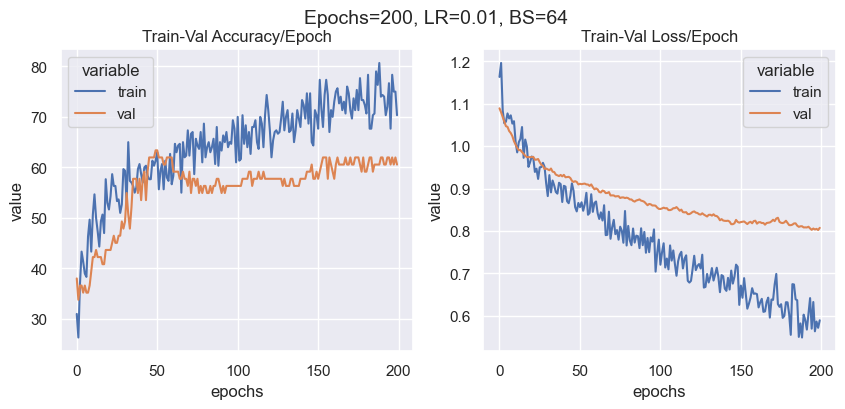

In [26]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4), dpi=100)
#fig.suptitle(f'Epochs={EPOCHS}, LR={LEARNING_RATE}, BS={BATCH_SIZE}', fontsize=14)
fig.suptitle(f'Epochs={EPOCHS}, LR={LEARNING_RATE}, BS={BATCH_SIZE}', fontsize=14)
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

### Evaluate test results

In [21]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [22]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.64      0.85      0.73        27
           1       0.95      0.53      0.68        38
           2       0.60      0.73      0.66        37

    accuracy                           0.69       102
   macro avg       0.73      0.70      0.69       102
weighted avg       0.74      0.69      0.68       102



[Text(0.5, 1.0, 'Epochs=200, LR=0.01, BS=64'),
 Text(0.5, 12.5, 'PREDICTION'),
 Text(30.5, 0.5, 'TRUE LABEL')]

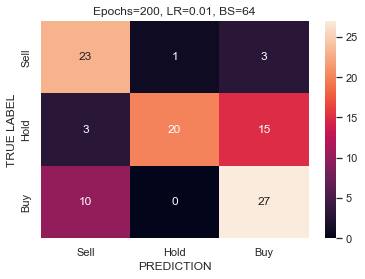

In [27]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list))
heatmap = sns.heatmap(confusion_matrix_df,  xticklabels=['Sell','Hold','Buy'], 
                      yticklabels=['Sell','Hold','Buy'],annot=True, cmap="rocket")
heatmap.set(title=f'Epochs={EPOCHS}, LR={LEARNING_RATE}, BS={BATCH_SIZE}', xlabel="PREDICTION", ylabel="TRUE LABEL",)